# Kaggle challenge: TV-series

### Key points

- use open interactions to filter items as to view an item one must open it first
- must recommend new items with no interactions -> at the end use all the data
- should use completion percentage to assume a implicit ranking for that item

In [116]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/Users/federicobono/Documenti/Polimi/RecSys/repos/RecSysChallenge2023-Team")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from datetime import timedelta
from ast import literal_eval

import random

from typing import Optional
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
n_users = 41629
n_items = 27968
n_features = 7

In [118]:
import Daniele.Utils.MyDataManager as dm
import Daniele.Utils.MatrixManipulation as mm


urm_views = dm.getURMviews()
urm_opens = dm.getURMopen()

urm_views_train, urm_views_test = split_train_in_two_percentage_global_sample(urm_views, train_percentage = 0.80)
urm_opens_train, urm_opens_test = split_train_in_two_percentage_global_sample(urm_opens, train_percentage = 0.80)

explicit_views = mm.explicitURM(urm_views_train,slope=0.01, n_remove=2750, shrink_bias=85,bias='item', new_val = 0)
explicit_opens = mm.explicitURM(urm_opens_train,slope=0.01, n_remove = 10000, shrink_bias = 25,bias='user', new_val = 30)

# explicitURM = mm.defaultExplicitURM(dm.getURMviews(),dm.getURMopen(),icml=dm.getICMl(),icmt=dm.getICMt(),appendICM=True)

  2%|▏         | 527/27968 [00:00<00:05, 5267.32it/s]

100%|██████████| 530696/530696 [00:00<00:00, 722955.23it/s]


In [119]:
urm_all = urm_views + urm_opens
urm_test = urm_views_test + urm_opens_test

In [120]:
# from Federico.reader import Reader
# reader = Reader()
# train_data, test_data = reader.get_train_test_split()
# data = reader.process_data(train_data)
# # data = data.loc[data.is_valid == 1].copy()
# URM_train = reader.data_processor.urm
# urm_test = reader.to_urm(test_data)

In [121]:
from Federico.OpenViewSplitRecommender import OpenViewSplitRecommender

recommender = OpenViewSplitRecommender(
    urm_views=explicit_views,
    urm_opens=explicit_opens,
    urm_all=urm_all,
    shape=(n_users, n_items)
)
#recommender.fit(topK=hyperparams.top_k, shrink=hyperparams.shrink)
recommender.fit()

OpenViewSplitRecommender: URM Detected 3461 (12.4%) items with no interactions.
fit: [50, 50, 25, 25]
ItemKNNCFRecommender: URM Detected 100 ( 0.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: URM Detected 1 ( 0.0%) users with no interactions.
RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
TopPopRecommender: URM Detected 1 ( 0.0%) users with no interactions.
TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 1105.23 column/sec. Elapsed time 25.31 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 844.63 column/sec. Elapsed time 33.11 sec


In [122]:
itemsView, scoresView = recommender.view_recommender.recommend([0], return_scores=True, cutoff=10)
itemsOpen, scoresOpen = recommender.open_recommender.recommend([0], return_scores=True, cutoff=10)
itemsHybrid, scoresHybrid = recommender.recommend([0], return_scores=True, cutoff=10)

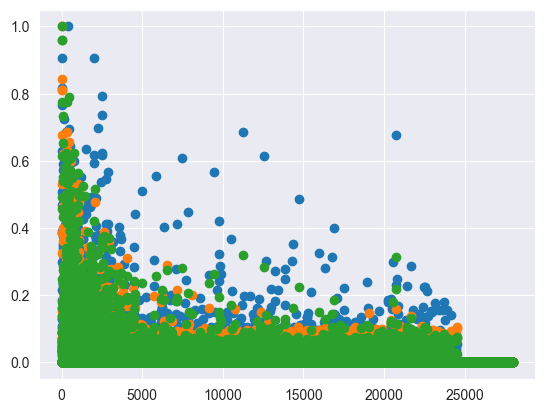

In [123]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalizedOpen = np.array(scoresOpen[0])
normalizedOpen[normalizedOpen == -np.inf] = 0
normalizedOpen = scaler.fit_transform(normalizedOpen.reshape(-1, 1))

normalizedView = np.array(scoresView[0])
normalizedView[normalizedView == -np.inf] = 0
normalizedView = scaler.fit_transform(normalizedView.reshape(-1, 1))

normalizedHybrid = np.array(scoresHybrid[0])
normalizedHybrid[normalizedHybrid == -np.inf] = 0
normalizedHybrid = scaler.fit_transform(normalizedHybrid.reshape(-1, 1))

plt.plot(normalizedOpen, 'o')
plt.plot(normalizedView, 'o')
plt.plot(normalizedHybrid, 'o')

In [52]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

itemRecommender = ItemKNNCFRecommender(explicit_views)
itemRecommender.fit(topK=50, shrink=25)

ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 924.14 column/sec. Elapsed time 30.26 sec


In [124]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator = EvaluatorHoldout(urm_test, [5, 10, 20], exclude_seen=True)
results_run_1, results_run_string_1 = evaluator.evaluateRecommender(recommender)

EvaluatorHoldout: Ignoring 276 ( 0.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 41353 (100.0%) in 59.16 sec. Users per second: 699


In [125]:
results_run_1

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99337,0.0,0.99337,0.026527,9.088883,0.994013,0.059262,0.673448,3.726647,0.107083
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99337,0.0,0.99337,0.034189,9.423613,0.99552,0.076378,0.69825,3.335225,0.217045
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99337,0.0,0.99337,0.045594,9.846899,0.996826,0.101857,0.729614,2.877304,0.44269


In [28]:
results_run_1

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.064338,0.073387,0.051473,0.040443,0.045911,0.153711,0.077723,0.057191,0.249404,0.176152,...,0.977996,0.243917,0.977996,0.050107,9.263796,0.992974,0.098527,0.686552,3.991055,0.127911
10,0.048456,0.080558,0.07512,0.024225,0.039707,0.163797,0.078602,0.058912,0.325031,0.197628,...,0.977996,0.317879,0.977996,0.068556,9.656849,0.994902,0.134803,0.715681,3.532653,0.259571
20,0.034639,0.105486,0.104678,0.013754,0.04089,0.168998,0.088592,0.052053,0.399749,0.211915,...,0.977996,0.390953,0.977996,0.094369,10.143485,0.996484,0.18556,0.751747,3.017,0.530393


In [ ]:
10,0.061212,0.083467,0.07227,0.031401,0.042143,0.194669,0.087201,0.066283,0.376606,0.244427,0.004354,0.186239,0.941654,0.994163,0.327376,0.063696,0.997919,0.992938,0.373946,0.992938,0.026482,9.019673,0.994491,0.052156,0.668485,3.673327,0.264678

In [ ]:
10,0.061986,0.084226,0.072906,0.031994,0.042882,0.1973,0.088428,0.067004,0.379848,0.248497,...,0.992938,0.377165,0.992938,0.057082,9.449858,0.994648,0.112421,0.700368,3.617532,0.271728

In [ ]:
# EaseR in views

10,0.063694,0.086838,0.07533,0.032988,0.044328,0.203829,0.091244,0.069025,0.388775,0.256453,0.004349,0.202218,0.933096,0.993307,0.524299,0.059248,0.997919,0.992938,0.386029,0.992938,0.040335,9.056643,0.993635,0.079438,0.671225,3.988502,0.264392

In [ ]:
# Using impressions
10,0.109706,0.119952,0.074853,0.065533,0.070709,0.305609,0.1372,0.088989,0.515234,0.438059,0.00454,0.184028,0.955113,0.995509,0.607418,0.06643,0.998817,0.997358,0.513873,0.997358,0.060017,9.648918,0.996203,0.193102,0.769192,1.746354,0.157587

In [ ]:
# Only views
10,0.055646,0.096959,0.091342,0.028524,0.048405,0.182006,0.092366,0.06916,0.351248,0.225798,0.004366,0.207924,0.936138,0.993611,0.61256,0.051373,0.982128,0.96279,0.338178,0.96279,0.059312,9.367277,0.994073,0.134488,0.710341,3.449254,0.401369

In [80]:
user_id = 800
user_profile_start = urm_test.indptr[user_id]
user_profile_end = urm_test.indptr[user_id + 1]

relevant_items = pd.DataFrame(urm_test.indices[user_profile_start:user_profile_end])
weights = recommender.get_weights(user_id)

relevant_items['is_relevant'] = 1
relevant_items.columns = ['item_id', 'is_relevant']
seen_items = pd.DataFrame(interactions_train[interactions_train['user_id'] == user_id]['item_id'])
seen_items['is_seen'] = 1

weights['is_relevant'] = relevant_items.set_index('item_id')
weights['is_seen'] = seen_items.set_index('item_id')

weights[weights.is_seen != 1]

,item_weights,w_impressions,view_weights,open_weights,user_weights,top_view_score,is_relevant,is_seen
0,0.0,0.0,0.0,0.0,0,0.000606,NaN,NaN
1,0.0,0.0,0.0,0.0,0,0.001544,NaN,NaN
2,0.0,0.0,0.0,0.0,0,0.001268,NaN,NaN
3,0.0,0.0,0.0,0.0,0,0.001599,NaN,NaN
4,0.0,0.0,0.0,0.0,0,0.001875,NaN,NaN
...,...,...,...,...,...,...,...,...
24502,0.0,0.0,0.0,0.0,0,0.000441,NaN,NaN
24503,0.0,0.0,0.0,0.0,0,0.000717,NaN,NaN
24504,0.0,0.0,0.0,0.0,0,0.000551,NaN,NaN
24505,0.0,0.0,0.0,0.0,0,0.000606,NaN,NaN


In [378]:
seen_items = interactions[interactions['user_id'] == 0]['item_id']
np.array(seen_items)

array([   21,   124,   808,  1326,  1995,  5068,  7603,  8540, 10682,
       13290, 14305, 18462,    11,    22,    24,    44,    54,   159,
         239,   575,   751,   987,  1715,  2218,  2256,  2257,  2292,
        2730,  4007,  4047,  4337,  4383,  5336,  5735,  5752,  6351,
        7301,  7499,  8056,  9275,  9374,  9879,  9960, 10013, 10218,
       10261, 11440, 12314, 12562, 12825, 13719, 14826, 16345, 16426,
       16868, 16876, 18194, 20558, 21108, 21586, 21848, 22307, 23170,
       23214, 24264, 24448])

In [329]:
view_recommendations = recommendations[0][:10]
open_recommendations = recommendations[1][:10]

pd.DataFrame([view_recommendations, open_recommendations])

,0,1,2,3,4,5,6,7,8,9
0,22,23,20,353,25,436,56,29,348,58
1,2488,450,448,2494,391,828,9463,1263,299,11250


## Submission

In [19]:
# Get data
from kaggle_challenges.challenge.OpenViewSplitRecommender import OpenViewSplitRecommender

interactions_all = interactions.copy()

data_processor = DataProcessor(data=interactions_all, params=hyperparams, num_users=num_users, num_items=num_items)
data_processor.process_data()
urm_all = data_processor.urm

In [20]:

best_recommender = OpenViewSplitRecommender(
    interactions=data_processor.data,
    ICM_type=icm_type,
    shape=(num_users, num_items)
)

In [21]:
%%time

best_recommender.fit()

fit: [50, 50, 25, 25]
ItemKNNCFRecommender: URM Detected 41629 (100.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 24507 (100.0%) items with no interactions.
Similarity column 24507 (100.0%), 4781.87 column/sec. Elapsed time 5.12 sec
Similarity column 24507 (100.0%), 3848.75 column/sec. Elapsed time 6.37 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1878.28 column/sec. Elapsed time 13.05 sec
CPU times: user 27.4 s, sys: 941 ms, total: 28.4 s
Wall time: 29.1 s


In [22]:
# Build recommendations

def build_recommendations(recommender: OpenViewSplitRecommender):
    target_users = pd.read_csv('data_target_users_test.csv')
    sub_data = pd.DataFrame(target_users, columns=['user_id'])

    sub_data['item_list'] = sub_data.apply(
        lambda row: recommender.recommend(
            user_id_array=row.user_id,
            remove_seen_flag=True
        )[0:10],
        axis=1
    )

    return sub_data

In [23]:
submission = build_recommendations(recommender=best_recommender)

In [24]:
sub_data = submission[['user_id', 'item_list']].copy()
sub_data['item_list'] = sub_data.item_list.apply(
    lambda row: " ".join([str(data) for data in row])
)
sub_data.to_csv("submission.csv", index=None)